## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import necessary libraries

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import datetime
from moviepy.editor import VideoFileClip
%matplotlib inline

### Helper Classes

In [2]:
class Line:
    def __init__(self):
        # Was line detected in the previous frame?
        self.prev_detected = False
        # Recent fits
        self.previous_fits = []
        # Polynomial coefficients
        self.current_fit = np.array([0, 0, 0])
        # Polynomial coefficients
        self.previous_fit = np.array([0, 0, 0])
        # Radius of curvature
        self.radius_of_curvature = 1000
        # Position of vehicle (dist from center)
        self.line_base_pos = None
        # For first frame
        self.initialized = False
        # Average fit
        self.average_fit = np.array([0, 0, 0])
        # Average curvature
        self.average_curvature = 0
        # Previous curves
        self.previous_curves = []
        # Frame counter
        self.frame_cnt = 0
        
class Lane:
    def __init__(self):
        self.bottom_width = 0
        self.top_width = 0
        self.average_bottom_width = 0
        self.average_top_width = 0
        self.previous_bottom_widths = []
        self.previous_top_widths = []

In [3]:
left_lane = Line()
right_lane = Line()
lane = Lane()

### Helper Functions

In [4]:
def show_img(image, gray):
    if gray: plt.imshow(image, cmap="gray")
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    plt.pause(0.00001)

def show_img_pair(image1, image2, gray1, gray2, title="nameless_image"):
    f, axarr = plt.subplots(1,2)
    f.suptitle(title, fontsize=12)
    f.set_size_inches(18, 12)
    if gray1:
        axarr[0].imshow(image1, cmap="gray")
    else:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        axarr[0].imshow(image1)
        
    if gray2:
        axarr[1].imshow(image2, cmap="gray")
    else:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        axarr[1].imshow(image2)
    plt.pause(0.00001)
#     f.savefig("output_images/"+title)

def show_gray_pair(image1, image2):
    f, axarr = plt.subplots(1,2)
    f.set_size_inches(18, 10)
    axarr[0].imshow(image1, cmap="gray")
    axarr[1].imshow(image2, cmap="gray")
    plt.pause(0.00001)
    
def calibrate_camera():
    """
    Calibrate camera based on chess board  images in camera_cal folder
    """
    objp = np.zeros((6*9,3), np.float32)   # Sine, the chessboard pattern has 6 inner rows and 9 inner columns
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    calib_images = glob.glob('camera_cal/calibration*.jpg')

    img_shape = (0,0)

    # Step through the list and search for chessboard corners
    for fname in calib_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_shape = gray.shape

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # DEBUG - Draw and display the corners
    #         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #         cv2.imshow('img',img)
    #         cv2.waitKey(500)
    # cv2.destroyAllWindows()

    # Get distortion coefficients and the camera matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[::-1], None, None)

    # DEBUG
    # for fname in images:
    #     img = cv2.imread(fname)
    #     dst = cv2.undistort(img, mtx, dist, None, mtx)
    #     ret, corners = cv2.findChessboardCorners(cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY),(9,6), None)
        # Draw and display the corners
    #     img = cv2.drawChessboardCorners(dst, (9,6), corners, ret)
    #     cv2.imshow('img',img)
    #     cv2.waitKey(500)
    # cv2.destroyAllWindows()
# Run it on test image
#     img = cv2.imread('camera_cal/test.jpg')
#     dst = cv2.undistort(img, mtx, dist, None, mtx)
#     show_img_pair(img, dst, gray1=False, gray2=False, title="Undistort_test_image")
    
    return mtx, dist
    
def applyThresholding(dst, s_thresh=(100, 255), b_thresh=(140,200), l_perc=(80,100), ksize=5, sx_perc=(90, 100)): # returns a binary image
    """
    Apply color thresholding in s_channel from HLS color space for yellow lanes.
    White lanes are also partially visible in s_channel thresholding. So, for white lanes threshold in l_channel 
    of LUV color space. Another thresholding of b_channel in lab color space gives good yellow lanes.
    Grradient thresholding is tricky as in challenge_video, there are rod marks which are not lanes, but due
    to gradient calcuilations those markings are also considered as lanes making the algorithm to fail to cover
    for white lane. Thus, I have not used gradient thresholding for these videos.
    """
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 1)

# change color space to hls - predominately yellow
    hls = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
#     show_img_pair(hls, s_channel, gray1=False, gray2=True, title="hls_and_s_channel")       
    
    # apply color thresholding
    s_binary = np.zeros_like(s_channel, dtype=np.uint8)
    s_binary[(s_thresh[0]<s_channel) & (s_channel<s_thresh[1])] = 1
#      show_gray_pair(s_channel, s_binary)
#     show_img_pair(s_channel, s_binary, gray1=True, gray2=True, title="s_channel-after-thresholding")       
    
# change color space to lab - Yellow lane
    lab = cv2.cvtColor(dst, cv2.COLOR_BGR2LAB)
    b_channel = lab[:,:,2]
#     show_img_pair(lab, b_channel, gray1=False, gray2=True, title="lab-and-b_channel")
    
    # apply color thresholding lab color space
    b_binary = np.zeros_like(b_channel, dtype=np.uint8)
    b_binary[(b_thresh[0]<b_channel) & (b_channel<b_thresh[1])] = 1
#     show_gray_pair(b_channel, b_binary)
#     show_img_pair(b_channel, b_binary, gray1=True, gray2=True, title="b_channel-after-thresholding") 
    
# Convert to LUV color space - Gets white lanes
    luv = cv2.cvtColor(dst, cv2.COLOR_BGR2Luv)
    l_channel = luv[:, :, 0]
#     show_img_pair(dst, luv, gray1=False, gray2=False, title="input-and-luv-color-space")

    # Create percentile-based thresholds
    l_thresh_min = np.percentile(l_channel.ravel(), l_perc[0])
    l_thresh_max = np.percentile(l_channel.ravel(), l_perc[1])
    
    # Threshold l color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
#     show_gray_pair(l_channel, l_binary)
#     show_img_pair(l_channel, l_binary, gray1=True, gray2=True, title="l_channel-after-thresholding") 
    
# Sobel x - Both yellow and white - but good for white as others are less capable of detecting white
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to limit lines away from vertical
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
#     show_img_pair(dst, scaled_sobel, gray1=False, gray2=True, title="input-and-scaled sobel")
    
    # Create percentile-based thresholds
    sx_thresh_min = np.percentile(scaled_sobel.ravel(), sx_perc[0])
    sx_thresh_max = np.percentile(scaled_sobel.ravel(), sx_perc[1])
    
    # Threshold edges (x gradient)
    sx_binary = np.zeros_like(sobelx, dtype=np.uint8)
    sx_binary[(scaled_sobel >= sx_thresh_min) & (scaled_sobel <= sx_thresh_max)] = 1
#     show_img_pair(dst, sx_binary, gray1=False, gray2=True, title="Input-after-gradient-thresholding")
    
# Calculate white lanes
    white_lanes = np.zeros_like(gray)
#     white_lanes[(sx_binary==1) | (l_binary==1)] = 1    # for video-1, projectvideo
#     white_lanes[(sx_binary==1) | (s_binary==1)] = 1    # for video-3,HardChallenge
    white_lanes[(s_binary==1) | (l_binary==1)] = 1  # for video-2, challenge video
      
# Calculate yellow lanes
    yellow_lanes = np.zeros_like(gray)
#     yellow_lanes[(s_binary==1) | (b_binary==1) | (sx_binary==1)] = 1
    yellow_lanes[(s_binary==1) | (b_binary==1)] = 1
    
    # to view contribution of individual lanes
    color_binary = np.dstack(( white_lanes, yellow_lanes, np.zeros_like(gray))) * 255
#     show_img(color_binary, gray=False)
    
    # output image
    combined_image = np.zeros_like(gray)
    combined_image[(white_lanes==1) | (yellow_lanes==1)] = 1
#     show_img(combined_image, gray=True)
#     show_img_pair(dst, combined_image, gray1=False, gray2=True, title="Combining-all-thresholds") 
    
    return combined_image


def applyPolygonMask(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def doPerspectiveTransform(src_pts, dst_pts, img):
    """
    Applies Perspective transform using src_pts and dst_points on input img
    Returns: warped image along with inverse warping Homography Matrix
    """    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    
    return warped, M_inv

def getBirdEyeView(dst,preproc_image):
    """
    Defines source points and destination points for the Homography transform
    Calculates the Homography matrix and applies it to the input pre-processed image
    Returns:Bird's eye viewed (warped) image
    """
# Polygon masking
    img_shape = preproc_image.shape
    vertices = np.array([[  (150, img_shape[0]-0), # 0-> 80 for hardchallenge                            
                            (img_shape[1]/2 - 100, img_shape[0]/2 + 100), # 100->140 for hardchallenge
                            (img_shape[1]/2 + 120, img_shape[0]/2 + 100), # 100->140 for hardchallenge
                            (img_shape[1]-100, img_shape[0]-0) # 0-> 80 for hardchallenge                            
                        ]], dtype=np.int32)
    
    # apply polygon masking
    polymasked_image = applyPolygonMask(preproc_image, vertices)
    overlay_polygon = roi_draw(polymasked_image, vertices)
#     show_img_pair(preproc_image, overlay_polygon, gray1=True, gray2=False, title="overlay-polygon-on-thresholded-image")
    
# perspective transform
#     src_pts = np.array([[  (150, img_shape[0]),
#                             (img_shape[1]/2 - 100, img_shape[0]/2 + 140),                
#                             (img_shape[1]/2 + 120, img_shape[0]/2 + 140),
#                             (img_shape[1]-100, img_shape[0])                            
#                         ]], dtype=np.float32)                    # This is required for HardChallenge video
    src_pts = np.float32(vertices)
    dst_pts = np.float32([[300,img_shape[0]], [300,0], [img_shape[1]-300,0], [img_shape[1]-300,img_shape[0]]])
    warped, M_inv = doPerspectiveTransform(src_pts, dst_pts, polymasked_image)
    debug_mask, _ = doPerspectiveTransform(src_pts, dst_pts, overlay_polygon)
#     show_gray_pair(polymasked_image, warped)
#     show_gray_pair(overlay_polygon, debug_mask)
#     show_img_pair(overlay_polygon, debug_mask, gray1=True, gray2=True, title="bird's-eye-view")
    
#     show_img_pair(dst, polymasked_image, gray1=False, gray2=True)
    return warped, polymasked_image, M_inv

def roi_draw(img, vertices):
    """
    Draws the polygon lines on the input image for debugging purposes
    """
    cp = np.copy(img)
    
    vertices = vertices[0]
    color=[1]
    thickness=2
    cv2.line(cp, (vertices[0][0], vertices[0][1]), (vertices[1][0], vertices[1][1]), color, thickness)
    cv2.line(cp, (vertices[1][0], vertices[1][1]), (vertices[2][0], vertices[2][1]), color, thickness)
    cv2.line(cp, (vertices[2][0], vertices[2][1]), (vertices[3][0], vertices[3][1]), color, thickness)
    cv2.line(cp, (vertices[3][0], vertices[3][1]), (vertices[0][0], vertices[0][1]), color, thickness)
    
    ret = np.dstack(( cp, np.zeros_like(img), img)) * 255
    
    return ret

def sliding_windows(birdview):
    """
    This is the core of the algorithm.
    First find all x and y coordinates of non-zero pixels.
    Next, an histogram along columns is analysed to obtain the starting positions. base_xleft and base_xright
    of left and right lanes along the y_max of the image. A small window is fitted around these starting
    positions. Since, we know that the lines move up, we expand the current window along xdirection by margin
    amount and shift the window up.
    Get coordinates of non-zero pixels in this window. Update the base_x* position according to pixels 
    in this window. Repeat this process for number of windows defined.    
    """
    bottom_half = birdview[birdview.shape[0]//2:, :] # consider only bottom half
    histogram = np.sum(bottom_half, axis=0)
    out_img = np.dstack((birdview, birdview, birdview))
#     plt.plot(histogram)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
     # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(birdview.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdview.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = birdview.shape[0] - (window+1)*window_height
        win_y_high = birdview.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox>=win_xleft_low) & (nonzerox<win_xleft_high) &
        (nonzeroy>=win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox>=win_xright_low) & (nonzerox<win_xright_high) &
        (nonzeroy>=win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds]).astype(np.int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds]).astype(np.int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Color left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, out_img

def fit_poly(leftx, lefty, rightx, righty):
    """
    Apply a polynomial of degree=2 fit for the curve lines
    """
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def calc_x_values(img_shape, left_fit, right_fit):
    """
    Given the polynomial coefficients, calculate the xpositions of the lanes
    """
    # Generate y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

    # Calculate x values using polynomial coeffs
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    return left_fitx, right_fitx

def search_around_poly(binary_warped, left_fit, right_fit):
    """
    Since sliding window is computationally expensive and redundant given the fact that there won't be too
    much change in lanes between frames, we can use this technique where we search for lane pixels around the 
    previous lanes by certain margin and update the polyfit equation similar to the sliding window technique.
    """
    # Margin for searching around curve
    margin = 60 # This margin is along x-axis

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Mask to get non-zero pixels that are next to the curve within margin
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                    left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                    left_fit[1] * nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                    right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Generate y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

    # Fit polynomial based on pixels found
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
    left_fitx, right_fitx = calc_x_values(binary_warped.shape, left_fit, right_fit)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    draw_img = np.zeros_like(out_img)

    # Color left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(draw_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(draw_img, np.int_([right_line_pts]), (0, 255, 0))
    out_img = cv2.addWeighted(out_img, 1, draw_img, 0.3, 0)

    return left_fit, right_fit, out_img

def sanity_check(left_lane, right_lane, lane):
    """
    Several sanity checks to ensure the polynomial coefficents are reasonable and the lane
    is having reasonable widths at the top and bottom.
    """
    # Calculate widths at top and bottom
    top_width_diff = abs(lane.top_width - lane.average_top_width)
    bottom_width_diff = abs(lane.bottom_width - lane.average_bottom_width)

    # Define sanity checks
    width_check_top = top_width_diff > 0.2 * lane.average_top_width or lane.top_width > 1.25 * lane.bottom_width
    width_check_bottom = bottom_width_diff > 0.05 * lane.average_bottom_width
    lane_intersect_check = lane.top_width < 0.0 or lane.bottom_width < 0.0
    curve_check = right_lane.current_fit[0] * left_lane.current_fit[0] < -0.00005 * 0.0001

    # Check if parameters are ok (skip for first frame)
    if (left_lane.frame_cnt > 1) and (right_lane.frame_cnt > 1):
        if width_check_bottom:
            result = False
        elif width_check_top:
            result = False
        elif lane_intersect_check:
            result = False
        elif curve_check:
            result = False
        else:
            result = True
    else:
        result = True

    return result

def average_fit(lane, num):
    """
    Average the polynomial coefficients from previous num frames for stable estimates
    """
    average_fit = lane.average_fit
    
    if len(lane.previous_fits) < num:
        lane.previous_fits.append(lane.current_fit)
    
    if len(lane.previous_fits)==num:
        lane.previous_fits.pop(0)
        lane.previous_fits.append(lane.current_fit)
        
    # If we have enough fits, calculate the average
    if len(lane.previous_fits) > 0:
        average_fit = np.mean(lane.previous_fits, axis=0)
    #else return previous average fit value
    
    return average_fit

def average_width(lane, n):
    """
    Average the lane top and bottom widths from previous num frames for stable estimates
    """
    average_bottom_width = lane.average_bottom_width
    average_top_width = lane.average_top_width

# BOTTOM WIDTH
    if len(lane.previous_bottom_widths) < n:
        lane.previous_bottom_widths.append(lane.bottom_width)
    
    # If amount of fits == n, remove the last element and add the current one
    if len(lane.previous_bottom_widths) == n:
        lane.previous_bottom_widths.pop(0)
        lane.previous_bottom_widths.append(lane.bottom_width)

    # If we have enough fits, calculate the average
    if (len(lane.previous_bottom_widths) > 0):
        average_bottom_width = np.mean(lane.previous_bottom_widths, axis = 0)

# TOP WIDTH
    if len(lane.previous_top_widths) < n:
        lane.previous_top_widths.append(lane.top_width)
    # If amount of fits == n, remove the last element and add the current one
    if len(lane.previous_top_widths) == n:
        lane.previous_top_widths.pop(0)
        lane.previous_top_widths.append(lane.top_width)

    # If we have enough fits, calculate the average
    if (len(lane.previous_top_widths) > 0):
        average_top_width = np.mean(lane.previous_top_widths, axis=0)

    return average_bottom_width, average_top_width

def measure_curvature_real(fit, img_shape):
    """
    Calcualte the radius of curvature using the standard formula
    https://en.wikipedia.org/wiki/Radius_of_curvature    
    """
    # Calculates the curvature of polynomial functions in meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Generate y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

    # Calculate x values using polynomial coeffs
    fitx = fit[0] * ploty ** 2 + fit[1] * ploty + fit[2]

    # Evaluate at bottom of image
    y_eval = np.max(ploty)

    # Fit curves with corrected axes
    curve_fit = np.polyfit(ploty * ym_per_pix, fitx * xm_per_pix, 2)

    # Calculate curvature values for left and right lanes
    curvature = ((1 + (2 * curve_fit[0] * y_eval * ym_per_pix + curve_fit[1]) ** 2) ** 1.5) / np.absolute(
        2 * curve_fit[0])

    return curvature

def average_curvature(lane, num):
    """
    Average the curvature from previous num frames for stable estimates
    """
    average_curve = lane.average_curvature

    if len(lane.previous_curves) < num:
        lane.previous_curves.append(lane.radius_of_curvature)
   
    if len(lane.previous_curves) == num:
        lane.previous_curves.pop(0)
        lane.previous_curves.append(lane.radius_of_curvature)

    # If we have enough fits, calculate the average
    if (len(lane.previous_curves) > 0):
        average_curve = np.mean(lane.previous_curves, axis=0)

    return average_curve   

def get_vehicle_position(x_range, left_lane_pos, right_lane_pos):
    """
    Get the position of the center of the lanes(assuming vehicle's center is also at this center)from the 
    center of the image horizontally(x-axis) in meters.    
    """
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Calculate position based on midpoint - center of lanes distance
    midpoint = x_range // 2
    center_of_lanes = (right_lane_pos + left_lane_pos) / 2
    position = midpoint - center_of_lanes

    # Get value in meters
    real_position = position * xm_per_pix

    return real_position

def warp_back(warped, undist, left_fit, right_fit, curvature, position, Minv):
    """
    Final step in the algortithm.
    Fill the region bounded the left and right lanes and warp it back into the image plane
    """
    # Generate y values
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])

    # Calculate x values
    left_fitx, right_fitx = calc_x_values(warped.shape, left_fit, right_fit)

    # Create image to draw lines onto
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

#     show_img_pair(warped, color_warp, gray1=True, gray2=False, title="Fill-region-inside-lane") 
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
#     show_img_pair(color_warp, newwarp, gray1=False, gray2=False, title="Warp-back-to-image-plane")

    # Combine the result with the original image
    lanes = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     show_img_pair(undist, lanes, gray1=False, gray2=False, title="overlay-on-input")
        
    # Texts to write on image
    curv_text = "Curvature: %.2f meters" % curvature
    if position>0:
        pos_text = "Position: %.2f right from center" % position
    else:
        pos_text = "Position: %.2f left from center" % position

    # Add text to image
    cv2.putText(lanes, curv_text, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))
    cv2.putText(lanes, pos_text, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))

    return lanes

In [5]:
# def pipeline(img, mtx, dist):
def pipeline(img, mtx, dist, count):
    
# for fname in images:
#     read input image
#     img = plt.imread(fname)
    
    #undisort images
    dst = cv2.undistort(img, mtx, dist, None, mtx)
#     show_img_pair(img, dst, gray1=False, gray2=False, title="Undistort_input_image")
    
    # apply HLS thresholding
    preproc_image = applyThresholding(dst)
#     show_img_pair(dst, preproc_image, gray1=False, gray2=True)
        
    # Get Bird's eye view
    birdview, poly_masked, M_inv = getBirdEyeView(dst, preproc_image)
            
    #find lane candidates
    # if prev frame calculation is missed on either lane perform histogram method to find lane points
    if not left_lane.prev_detected or not right_lane.prev_detected:
        try:
#             print("Doing sliding window")
            left_fit, right_fit, out_img =  sliding_windows(birdview)
#             show_img(out_img, gray=False)
#             show_img_pair(preproc_image, out_img, gray1=True, gray2=False, title="sliding-windows-on-warped-image") 
        except (RuntimeError, TypeError):
#             print("Error during sliding window")
            left_fit = left_lane.previous_fit
            right_fit = right_lane.previous_fit
    else:# if previous detected is true, search a region around previous line
        try:
#             print("searcghing around poly")
            left_fit, right_fit, out_img = search_around_poly(birdview, left_lane.previous_fit, right_lane.previous_fit)
#             show_img(out_img, gray=False)
        except (RuntimeError, TypeError):
#             print("error in searching for around poly")
            try:
                print("error in searching for poly, so trying to do sliding window")
                left_fit, right_fit, out_img = sliding_windows(birdview)
#                 show_img(out_img, gray=False)
            # if nothing was found, use previous fit
            except (RuntimeError, TypeError):
                print("ERROR IN error in searching for poly, so trying to do sliding window")
                left_fit = left_lane.previous_fit
                right_fit = right_lane.previous_fit
#                 out_img = np.zeros_like(img)

    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    # Calculate base position of lane lines to get lane distance
    
    left_lane.line_base_pos = left_fit[0] * (birdview.shape[0] - 1) ** 2 + left_fit[1] * (birdview.shape[0] - 1) + left_fit[2]
    right_lane.line_base_pos = right_fit[0] * (birdview.shape[0] - 1) ** 2 + right_fit[1] * (birdview.shape[0] - 1) + right_fit[2]
    left_lane.line_mid_pos = left_fit[0] * (birdview.shape[0] // 2) ** 2 + left_fit[1] * (birdview.shape[0] // 2) + left_fit[2]
    right_lane.line_mid_pos = right_fit[0] * (birdview.shape[0] // 2) ** 2 + right_fit[1] * (birdview.shape[0] // 2) + right_fit[2]

    # Calculate top and bottom position of lane lines for sanity check
    lane.top_width = right_fit[2] - left_fit[2] # because ypos=0 at the top
    lane.bottom_width = right_lane.line_base_pos - left_lane.line_base_pos
    lane.middle_width = right_lane.line_mid_pos - left_lane.line_mid_pos
    
    # Check if the lane fit above makes sense using trivial tests
    
     # Check if values make sense
    if sanity_check(left_lane, right_lane, lane) is False:
        # If fit is not good, use previous values and indicate that lanes were not found
#         print("sanity check failed!!")
        left_lane.current_fit = left_lane.previous_fit
        right_lane.current_fit = right_lane.previous_fit
        left_lane.prev_detected = False
        right_lane.prev_detected = False
    else:
        # If fit is good, use current values and indicate that lanes were found
        if left_lane.prev_detected == False or right_lane.prev_detected == False:
            left_lane.previous_fits.clear()
            right_lane.previous_fits.clear()
        left_lane.prev_detected = True
        right_lane.prev_detected = True
        left_lane.initialized = True
        right_lane.initialized = True
        left_lane.frame_cnt += 1
        right_lane.frame_cnt += 1
        
    
    # Average the fits over several frames for stability  
    left_lane.average_fit = average_fit(left_lane, 3)
    right_lane.average_fit = average_fit(right_lane, 3)
    
    lane.average_bottom_width, lane.average_top_width = average_width(lane, 3)

    # Determine lane curvature and position of the vehicle
    left_lane.radius_of_curvature = measure_curvature_real(left_fit, birdview.shape)
    right_lane.radius_of_curvature = measure_curvature_real(right_fit, birdview.shape)
    
    left_lane.average_curvature = average_curvature(left_lane, 3)
    right_lane.average_curvature = average_curvature(right_lane, 3)
    curvature = left_lane.average_curvature + right_lane.average_curvature / 2
    
    # Determine vehicle position w.r.t lanes
    left_lane.line_base_pos = left_fit[0] * (birdview.shape[0] - 1) ** 2 + left_fit[1] * (birdview.shape[0] - 1) + left_fit[2]
    right_lane.line_base_pos = right_fit[0] * (birdview.shape[0] - 1) ** 2 + right_fit[1] * (birdview.shape[0] - 1) + right_fit[2]
    vehicle_position = get_vehicle_position(birdview.shape[1], left_lane.line_base_pos, right_lane.line_base_pos)
    
    # Warp back onto camera view
    output_image = warp_back(birdview, dst, left_lane.average_fit, right_lane.average_fit, curvature,
                                  vehicle_position, M_inv)

    # Set current values as previous values for next frame
    left_lane.previous_fit = left_lane.current_fit
    right_lane.previous_fit = right_lane.current_fit
    
    left_lane.current_fit = [np.array([False])]
    right_lane.current_fit = [np.array([False])]

#     show_img_pair(dst, output_image, gray1=False, gray2=False)
#     cv2.imwrite("output_images/debug/frame%d.jpg" % count, output_image)

    return output_image

In [6]:
def find_ego_lane_region(filename):
    # for reading video
    mtx, dist = calibrate_camera()
    vidcap = cv2.VideoCapture(filename)
    success, image = vidcap.read()
    shape = image.shape
    # for writing video
#     name = 'output_videos/output_' + filename
#     fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#     out_video = cv2.VideoWriter(name, fourcc, 30.0, (shape[1],shape[0]))
    count = 0
    while success:
        output_image = pipeline(image, mtx, dist, count)
#         out_video.write(output_image)
        success, image = vidcap.read()
        count += 1
#         break
#     out_video.release()

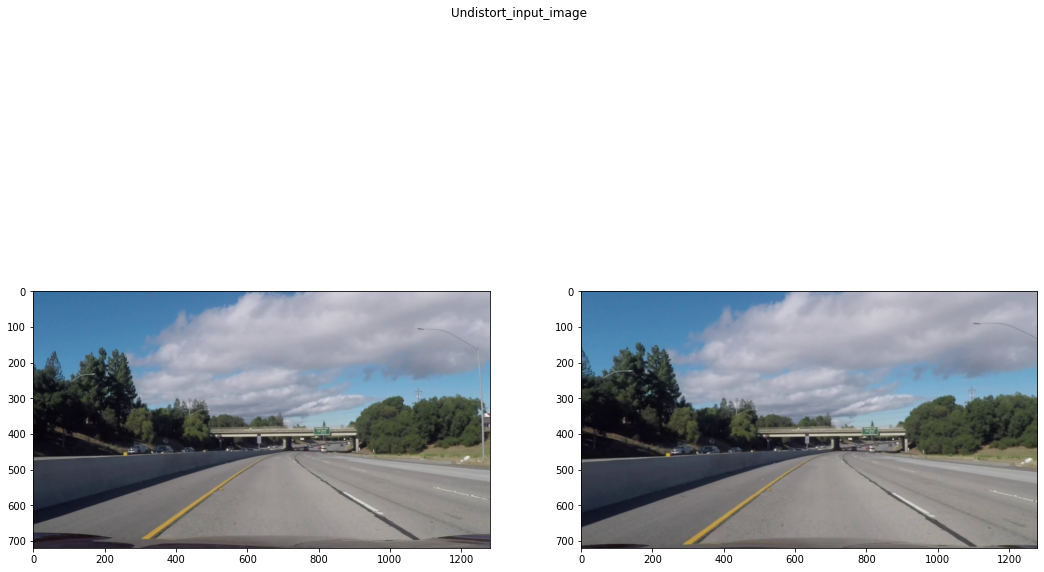

In [7]:
# find_ego_lane_region(filename = 'project_video.mp4')
find_ego_lane_region(filename = 'challenge_video.mp4')
# find_ego_lane_region(filename = 'harder_challenge_video.mp4')